In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# load the sales data set
sales_data = pd.read_csv('../../../Data/SalesData.csv')
sales_data.head()

sales_data = sales_data[sales_data['Category'] == 'Mesotherapy'] 

pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded2 = pd.concat([sales_data, pharmacy_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Product'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded3 = pd.concat([sales_data_encoded2, product_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Location'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded3, product_onehot], axis=1)

sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Pharmacy 1,...,"Brazil, USA, Blank, IE, Zimbabwe, Zurich",Ireland & Northern Ireland,London,"NorthEast, Midlands",NorthWest,Outside London M25,Outside London the rest,"Scotland, Newcastle",SouthEast,SouthWest
13,1-12-2015,12,4,2015,1,Injection 13,Mesotherapy,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
36,1-1-2016,1,1,2016,1,Injection 13,Mesotherapy,Pharmacy 2,NorthWest,0,...,0,0,0,0,1,0,0,0,0,0
37,1-1-2016,1,1,2016,1,Injection 13,Mesotherapy,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
38,1-1-2016,1,1,2016,1,Injection 13,Mesotherapy,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
78,1-2-2016,2,1,2016,1,Injection 13,Mesotherapy,Pharmacy 2,"Scotland, Newcastle",0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67191,1-3-2022,3,1,2022,1,Injection 13,Mesotherapy,Pharmacy 9,London,0,...,0,0,1,0,0,0,0,0,0,0
67428,1-3-2022,3,1,2022,1,Injection 13,Mesotherapy,Pharmacy 9,London,0,...,0,0,1,0,0,0,0,0,0,0
67441,1-3-2022,3,1,2022,1,Injection 13,Mesotherapy,Pharmacy 9,"Scotland, Newcastle",0,...,0,0,0,0,0,0,0,1,0,0
68019,1-3-2022,3,1,2022,1,Injection 13,Mesotherapy,Pharmacy 1,Outside London the rest,1,...,0,0,0,0,0,0,1,0,0,0


In [2]:
list(sales_data_encoded.columns)

['Date',
 'Month',
 'Quarter',
 'Year',
 'Qty',
 'Product',
 'Category',
 'Pharmacy',
 'Location',
 'Pharmacy 1',
 'Pharmacy 10',
 'Pharmacy 2',
 'Pharmacy 3',
 'Pharmacy 5',
 'Pharmacy 7',
 'Pharmacy 8',
 'Pharmacy 9',
 'Injection 12',
 'Injection 13',
 'Brazil, USA, Blank, IE, Zimbabwe, Zurich',
 'Ireland & Northern Ireland',
 'London',
 'NorthEast, Midlands',
 'NorthWest',
 'Outside London M25',
 'Outside London the rest',
 'Scotland, Newcastle',
 'SouthEast',
 'SouthWest']

In [3]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Pharmacy 1' : 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 7' : 'sum',
    'Pharmacy 8' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Injection 12' :'sum',
    'Injection 13' :'sum',
    'Brazil, USA, Blank, IE, Zimbabwe, Zurich' : 'sum',
    'Ireland & Northern Ireland' : 'sum',
    'London' : 'sum',
    'NorthEast, Midlands' : 'sum',
    'NorthWest' : 'sum',
    'Outside London M25' : 'sum',
    'Outside London the rest' : 'sum',
    'Scotland, Newcastle' : 'sum',
    'SouthEast' : 'sum',
    'SouthWest' : 'sum'
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

#print(sales_data_lagged)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)


# split the data into training and testing sets
train_size = int(len(sales_data_lagged) * 0.8)
train_data = sales_data_lagged[:train_size]
test_data = sales_data_lagged[train_size:]


In [4]:
# train a random forest model

# model = RandomForestRegressor(n_estimators=100, max_depth=5)
# model.fit(train_data.iloc[:, 2:], train_data['Qty'])

criterion = ['friedman_mse', 'squared_error']
max_depth = [5, 10]
min_samples_leaf = [1, 2]
max_features = ['log2', 'sqrt']
loss = ['squared_error', 'huber', 'quantile']

random_grid_gbr = {
    'criterion' : criterion,
    'max_depth' : max_depth,
    'min_samples_leaf' : min_samples_leaf,
    'max_features' : max_features,
    'loss' : loss
}

gbr = GradientBoostingRegressor()
# gbr_random = RandomizedSearchCV(
#     estimator=gbr,
#     param_distributions=random_grid_gbr,
#     n_iter=10,
#     cv=5,
#     verbose=5,
#     random_state=0
# )
gbr_random = GridSearchCV(
    estimator=gbr,
    param_grid = random_grid_gbr,
    cv=5,
    verbose=5
)

In [5]:
gbr_random.fit(train_data.iloc[:, 2:], train_data['Qty'])


# make predictions for the test data
predictions = gbr_random.predict(test_data.iloc[:, 2:])

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.606 total time=   0.0s
[CV 2/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.743 total time=   0.0s
[CV 3/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.457 total time=   0.0s
[CV 4/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.677 total time=   0.0s
[CV 5/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=1;, score=0.653 total time=   0.0s
[CV 1/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min_samples_leaf=2;, score=0.689 total time=   0.0s
[CV 2/5] END criterion=friedman_mse, loss=squared_error, max_depth=5, max_features=log2, min

In [6]:
# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - test_data['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

# calculate the mean squared error
mse = mean_squared_error(test_data['Qty'], predictions)
print('MSE:', mse)

# calculate the r2 score
r2_score = r2_score(test_data['Qty'], predictions)
print('R^2 Score:', r2_score)

# calculate explained variance score
explained_variance_score = explained_variance_score(test_data['Qty'], predictions)
print('Explained Variance Score:', explained_variance_score)

# calculate max error
max_error = max_error(test_data['Qty'], predictions)
print('Max Error:', max_error)


print([test_data['Date'].values, test_data['Qty'].values, predictions])

RMSE: 2.9543002283279707
MSE: 8.7278898390987
R^2 Score: 0.2942519699484786
Explained Variance Score: 0.3340445456761336
Max Error: 6.65622554935727
[array(['1-7-2021', '1-8-2016', '1-8-2017', '1-8-2018', '1-8-2019',
       '1-8-2020', '1-8-2021', '1-9-2016', '1-9-2017', '1-9-2018',
       '1-9-2019', '1-9-2020', '1-9-2021'], dtype=object), array([11,  4,  1,  3,  6,  7,  6,  3,  3,  5,  2,  4, 14], dtype=int64), array([8.97200584, 3.10705875, 1.57159554, 6.1069909 , 7.04257282,
       8.4584737 , 6.19460556, 2.15856133, 4.25281921, 9.305537  ,
       6.6019907 , 7.00358017, 7.34377445])]


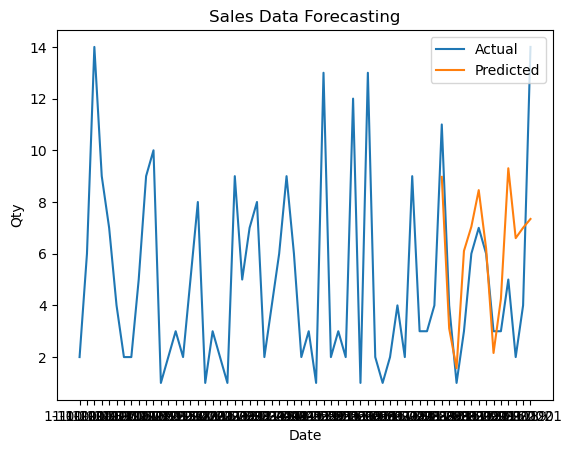

In [7]:
sales_data_lagged['predicted_quantity'] = pd.Series(predictions, index=test_data.index)
sales_data_lagged= sales_data_lagged.sort_values(by=['Date'])

# plot the actual and predicted quantities against date
plt.plot(sales_data_lagged['Date'], sales_data_lagged['Qty'], label='Actual')
plt.plot(sales_data_lagged['Date'], sales_data_lagged['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()

In [8]:
gbr_random.best_params_

{'criterion': 'friedman_mse',
 'loss': 'squared_error',
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 1}

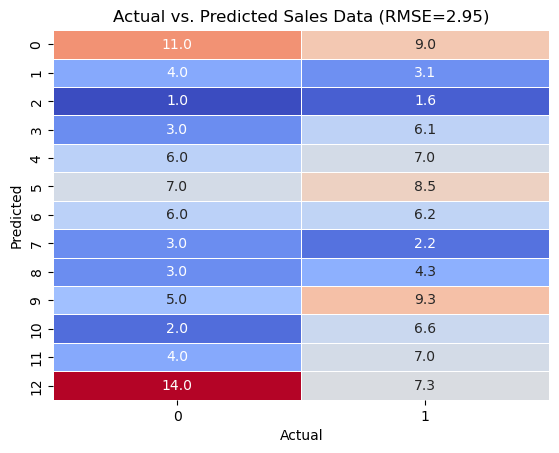

In [9]:
matrix_data = np.column_stack((test_data['Qty'].values, predictions))

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (RMSE={rmse:.2f})')
plt.show()